In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
bs = 64
# MNIST Dataset
train_dataset = MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 78439114.26it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63554928.55it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22848628.42it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12933149.20it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [4]:
inputs, classes = next(iter(train_loader))
print(inputs.shape)
print(classes)
x_dim = inputs.shape[-2] * inputs.shape[-1]
print("Dimension of input picture =", x_dim)

torch.Size([64, 1, 28, 28])
tensor([2, 6, 8, 1, 0, 9, 9, 8, 3, 3, 4, 7, 2, 1, 3, 0, 5, 9, 9, 2, 9, 8, 0, 2,
        1, 1, 2, 9, 8, 4, 5, 7, 7, 1, 9, 2, 3, 9, 9, 7, 3, 9, 8, 9, 6, 4, 8, 6,
        1, 1, 8, 0, 2, 7, 7, 2, 3, 4, 6, 0, 6, 8, 8, 3])
Dimension of input picture = 784


In [5]:
import torch

import torch.nn.functional as F

class Encoder(torch.nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, latent_dim=20):
        super(Encoder, self).__init__()
        self.enc1 = torch.nn.Linear(x_dim, h_dim1)
        self.enc2 = torch.nn.Linear(h_dim1, h_dim2)
        self.mean_x = torch.nn.Linear(h_dim2,latent_dim)
        self.logvar_x = torch.nn.Linear(h_dim2, latent_dim)

    def forward(self,inputs):
        x = self.enc1(inputs)
        x = F.relu(x)
        x = self.enc2(x)
        x = F.relu(x)
        z_mean = self.mean_x(x)
        z_log_var = self.logvar_x(x)
        return z_mean, z_log_var

In [6]:
class Decoder(torch.nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, latent_dim=20):
        super(Decoder, self).__init__()
        self.dec1 = torch.nn.Linear(latent_dim, h_dim2)
        self.dec2 = torch.nn.Linear(h_dim2, h_dim1)
        self.out = torch.nn.Linear(h_dim1, x_dim)

    def forward(self,z):
        z = self.dec1(z)
        z = F.relu(z)
        z = self.dec2(z)
        z = F.relu(z)
        return F.sigmoid(self.out(z))

In [7]:
class VAE(torch.nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, latent_dim)
        self.decoder = Decoder( x_dim, h_dim1, h_dim2, latent_dim)

    def forward(self,inputs):
        z_mean, z_log_var = self.encoder(inputs.view(-1, 784))
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + (eps * std)

In [8]:
vae = VAE(x_dim = x_dim, h_dim1 = 512, h_dim2 = 256, latent_dim = 2)
if torch.cuda.is_available():
    vae.cuda()

In [9]:
vae

VAE(
  (encoder): Encoder(
    (enc1): Linear(in_features=784, out_features=512, bias=True)
    (enc2): Linear(in_features=512, out_features=256, bias=True)
    (mean_x): Linear(in_features=256, out_features=2, bias=True)
    (logvar_x): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (dec1): Linear(in_features=2, out_features=256, bias=True)
    (dec2): Linear(in_features=256, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [10]:
def final_loss(reconstruction, train_x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruction, train_x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [11]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses

In [12]:
def train_vae(vae, train_loader, num_epochs = 50, running_test = False):
    vae.train()
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.cuda()
            optimizer.zero_grad()

            recon_batch, mu, log_var = vae(data)
            loss = final_loss(recon_batch, data, mu, log_var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() / len(data)))
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
        train_loss_list.append(train_loss / len(train_loader.dataset))
        if running_test:
            vae.eval()
            test_loss = 0
            with torch.no_grad():
                for data, _ in test_loader:
                    data = data.cuda()
                    recon, mu, log_var = vae(data)
                    # sum up batch loss
                    test_loss += final_loss(recon, data, mu, log_var).item()
            test_loss /= len(test_loader.dataset)
            print('====> Test set loss: {:.4f}'.format(test_loss))
            test_loss_list.append(test_loss)
    return train_loss_list, test_loss_list
    

In [13]:
train_loss_list, test_loss_list = train_vae(vae, train_loader, num_epochs = 50, running_test = True)

Train Epoch: 0 [0/60000 (0%)]	Loss: 543.835266
Train Epoch: 0 [6400/60000 (11%)]	Loss: 199.832352
Train Epoch: 0 [12800/60000 (21%)]	Loss: 172.893127
Train Epoch: 0 [19200/60000 (32%)]	Loss: 170.525574
Train Epoch: 0 [25600/60000 (43%)]	Loss: 167.034851
Train Epoch: 0 [32000/60000 (53%)]	Loss: 175.860962
Train Epoch: 0 [38400/60000 (64%)]	Loss: 162.139862
Train Epoch: 0 [44800/60000 (75%)]	Loss: 167.015717
Train Epoch: 0 [51200/60000 (85%)]	Loss: 167.600815
Train Epoch: 0 [57600/60000 (96%)]	Loss: 155.763275
====> Epoch: 0 Average loss: 174.3353
====> Test set loss: 159.8442
Train Epoch: 1 [0/60000 (0%)]	Loss: 167.554337
Train Epoch: 1 [6400/60000 (11%)]	Loss: 161.785492
Train Epoch: 1 [12800/60000 (21%)]	Loss: 150.883530
Train Epoch: 1 [19200/60000 (32%)]	Loss: 162.290039
Train Epoch: 1 [25600/60000 (43%)]	Loss: 166.331512
Train Epoch: 1 [32000/60000 (53%)]	Loss: 150.575287
Train Epoch: 1 [38400/60000 (64%)]	Loss: 154.710190
Train Epoch: 1 [44800/60000 (75%)]	Loss: 162.933609
Train Ep

## Generating Data

In [58]:
torch.save(vae.state_dict(), 'vae_model.pt')

tensor([[-1.0408,  0.9166],
        [-0.8480,  0.5266],
        [ 0.0299, -0.0498],
        [ 1.0651,  0.8860],
        [-0.8110,  0.6737],
        [ 0.1289,  2.7631],
        [ 0.1405,  1.1191],
        [ 0.3152,  1.7528],
        [-0.7396, -1.2425]], device='cuda:0')


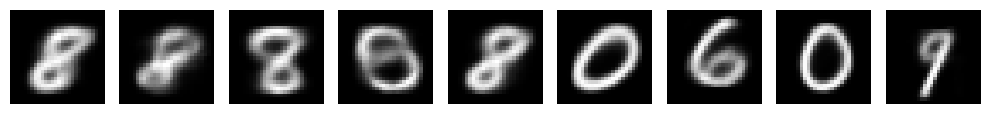

In [35]:
import matplotlib.pyplot as plt

def generate_digits(model, num_digits=9):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    with torch.no_grad():
        torch.manual_seed(2)
        z = torch.randn(num_digits, 2).to(device)
        print(z)
        generated = model.decoder(z).cpu().view(-1, 1, 28, 28)

    # Plot the generated digits using Matplotlib
    fig, axes = plt.subplots(1, num_digits, figsize=(10, 2))
    for i in range(num_digits):
        axes[i].imshow(generated[i][0], cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    return z
    
# Generate digits using the trained VAE and visualize them
z = generate_digits(vae)

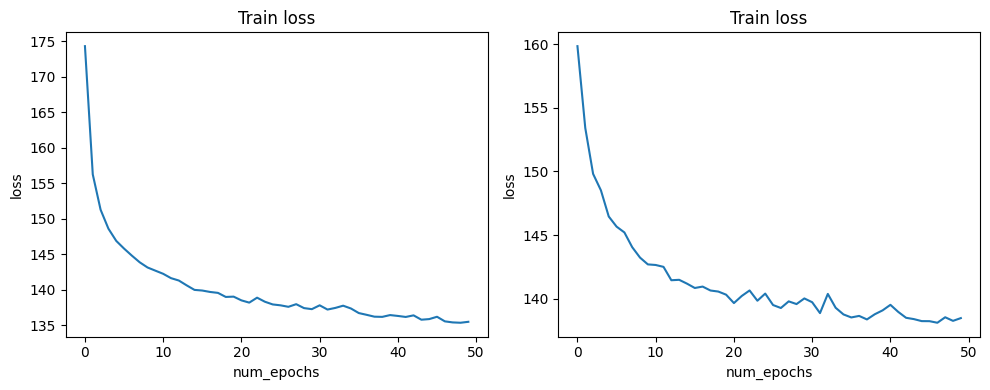

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(train_loss_list)
axes[0].set_xlabel('num_epochs')
axes[0].set_ylabel('loss')
axes[0].set_title('Train loss')

axes[1].plot(test_loss_list)
axes[1].set_xlabel('num_epochs')
axes[1].set_ylabel('loss')
axes[1].set_title('Train loss')

plt.tight_layout()
plt.show()

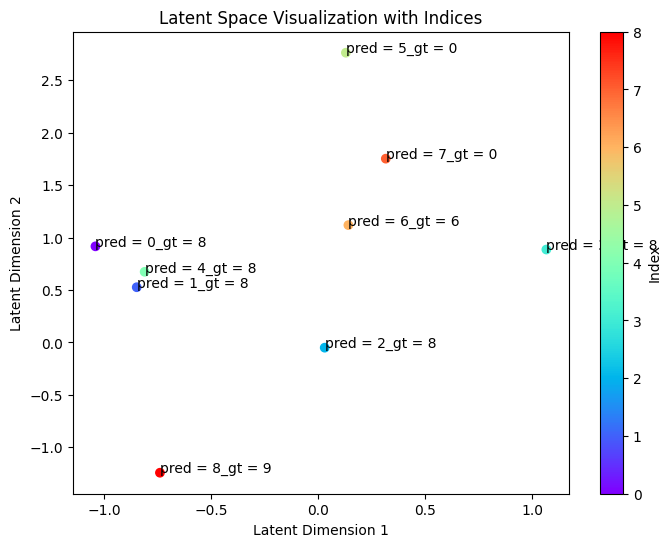

In [57]:
latent_space = z.to("cpu")
indices = np.arange(9)
pred_list = [8, 8, 8, 8, 8, 0, 6, 0, 9]
plt.figure(figsize=(8, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=indices, cmap='rainbow')
plt.colorbar(label='Index')
for i, index in enumerate(indices):
    plt.text(latent_space[i, 0], latent_space[i, 1],"pred = "+str(index)+"_gt = "+str(pred_list[index]), fontsize=10, color='black')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization with Indices')
plt.show()

## Reconstruct data

In [39]:
inputs, classes = next(iter(test_loader))
print(inputs.shape)

torch.Size([64, 1, 28, 28])


In [40]:
torch.manual_seed(2)
num_digits = 9
indices = torch.randint(0, 64, (num_digits,))
def plot_data(inputs, classes, indices, num_digits = 9):
    data = inputs[indices]
    label = np.array(classes[indices])
    fig, axes = plt.subplots(1, num_digits, figsize=(10, 2))
    for i in range(num_digits):
        axes[i].imshow(data[i][0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(str(label[i]))
    plt.tight_layout()
    plt.show()

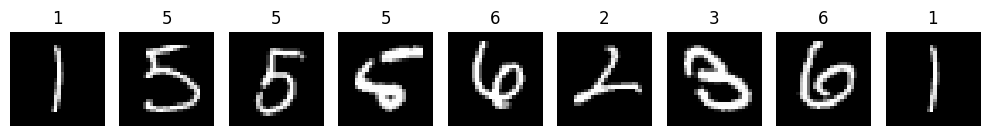

In [41]:
plot_data(inputs, classes, indices, num_digits = 9)

In [43]:
reconstructed, z_mean, z_log_var = vae.forward(inputs[indices].to("cuda"))

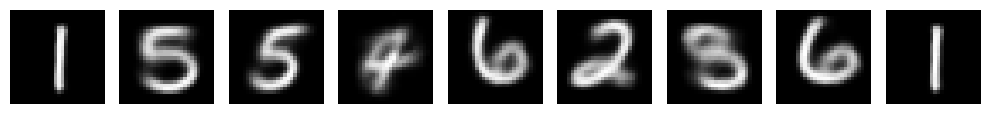

In [54]:
reconstructed_data = reconstructed.view(-1, 28, 28).to("cpu").detach().numpy()
fig, axes = plt.subplots(1, num_digits, figsize=(10, 2))
for i in range(num_digits):
    axes[i].imshow(reconstructed_data[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()